In [1]:
from __future__ import print_function

import double_log
def print(*args, **kwargs):
    return double_log.print(*args, **kwargs)


import keras
import pickle
import operator
import numpy as np
import pandas as pd
import tensorflow as tf
import plot_conf_matrix as pcm
from keras import backend as K
from keras.datasets import mnist
from sklearn.metrics import f1_score
from keras.engine.topology import Layer
from keras.models import Sequential, Model
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from keras.layers import Conv2D, Conv1D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten, Softmax, Reshape

print("===== IMPORTING ||| SCRIPT STARTS ||| LOGGING PURPOSE ======")

/home/nyuad/anaconda2/envs/Gabor/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


=====IMPORTING|||SCRIPT STARTS|||LOGGING PURPOSE======


## Loading Data, Splitting, and Correct Fromating

In [2]:
with open('../../Images/MNIST_noisy/noisy_mnist_50.pickle', 'rb') as fp:
    mnist_noise = pickle.load(fp)

60000 train samples
10000 test samples
30013  elems are true in train
5006  elems are true in test


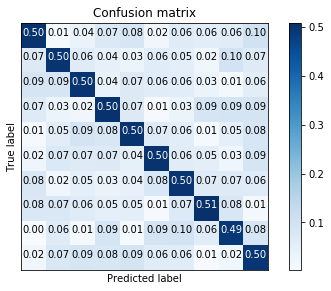

In [3]:
batch_size = 128
num_classes = 10
epochs = 10

# input image dimensions
img_rows, img_cols = 28, 28

# load noisy lables from file, while the iamges and clean labels from built-in function
y_train = mnist_noise['train']
y_test = mnist_noise['test']
(x_train, y_train_clean), (x_test, y_test_clean) = mnist.load_data()

# transform data to what Keras likes
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
cm = confusion_matrix(y_train_clean, y_train)
cm = confusion_matrix(y_train_clean, y_train).astype('float') / cm.sum(axis=1)[:, np.newaxis]
# 10-fold cross validation
folds = list(StratifiedKFold(n_splits=10, shuffle=True, random_state=1).split(x_train, y_train))

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(np.sum(y_train == y_train_clean), " elems are true in train")
print(np.sum(y_test == y_test_clean), " elems are true in test")
pcm.plot_confusion_matrix(y_train_clean, y_train, normalize=True)

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_test_clean = keras.utils.to_categorical(y_test_clean, num_classes)

## SWITCH BETWEEN NOISY AND CLEAN DATA FOR TESTING 
#y_test = y_test_clean

## Define noise layer and models

In [4]:
#returns the confusion matrix (the perfectly known noise distribution) in the NoiseLayer initializer
def confusion_kernel(shape):
    return cm

#noise layer defined according to Keras functional API
class NoiseLayer(Layer):
    def __init__(self, output_dim, dynamic=True, **kwargs):
        self.output_dim = output_dim
        self.dynamic = dynamic
        super(NoiseLayer, self).__init__(**kwargs)
    
    def build(self, input_shape):
        # weight matrix
        self.kernel = self.add_weight(name='kernel', 
                                      shape=input_shape,
                                      initializer=confusion_kernel,
                                      trainable=self.dynamic) #change this to false for static weights
        super(NoiseLayer, self).build(input_shape)
    
    #forward pass - vector matrix multiplication of the input and the weights. FIXED for batches
    def call(self, x):
        return tf.nn.softmax(tf.einsum('bn,nm->bn',x, self.kernel))

    def compute_output_shape(self, input_shape):
        return (1, self.output_dim)

In [5]:
def build_default():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=[keras.metrics.categorical_accuracy])
    return model

def build_noisy(trainable):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    # attach noise layer
    model.add(NoiseLayer(num_classes, dynamic=trainable))
    model.add(Dropout(0.1))

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=[keras.metrics.categorical_accuracy])
    return model

## Run default model 5 times with cross validation

In [6]:
#for logging in cnn.log
print_callback = keras.callbacks.LambdaCallback(
        on_epoch_end=lambda epoch,logs: double_log.logger.debug('epoch: '+ str(epoch+1)+ ' logs: '+ str(logs)))

# Testing default moel without noise model attached
def_model = build_default()
results_def = []
for i in range(5):
    for j, (train_idx, val_idx) in enumerate(folds[0:5]):
        print("===Default - Fold ",j," - Training Round ",i," ======")
        x_train_cv = x_train[train_idx]
        y_train_cv = y_train[train_idx]
        x_valid_cv = x_train[val_idx]
        y_valid_cv= y_train[val_idx]
        
        def_model.fit(x_train_cv, y_train_cv,
                  batch_size=batch_size,
                  epochs=epochs,
                  verbose=1,
                  validation_data=(x_valid_cv, y_valid_cv),
                  callbacks=[print_callback])
        
        pred = def_model.predict(x_test, verbose=1)

        f1 = f1_score([max(enumerate(i), key=operator.itemgetter(1))[0] for i in pred.tolist()], [max(enumerate(i), key=operator.itemgetter(1))[0] for i in y_test_clean.tolist()], average='micro')
        results_def.append(f1)
        print('F1-score:', f1, "\n===================")
        
print("\nAverage model score: %.3f%% (+/- %.3f%%)" % (np.mean(results_def), np.std(results_def)))
print(results_def, '\n\n')

===Default - Fold  0  - Training Round  0  ======
Train on 53995 samples, validate on 6005 samples
Epoch 1/10
53995/53995 [==============================] - 7s 126us/step - loss: 1.9379 - categorical_accuracy: 0.4308 - val_loss: 1.7999 - val_categorical_accuracy: 0.4933
Epoch 2/10
53995/53995 [==============================] - 5s 94us/step - loss: 1.8532 - categorical_accuracy: 0.4726 - val_loss: 1.7661 - val_categorical_accuracy: 0.4968
Epoch 3/10
53995/53995 [==============================] - 5s 95us/step - loss: 1.8274 - categorical_accuracy: 0.4792 - val_loss: 1.7662 - val_categorical_accuracy: 0.4996
Epoch 4/10
53995/53995 [==============================] - 5s 95us/step - loss: 1.8114 - categorical_accuracy: 0.4821 - val_loss: 1.7613 - val_categorical_accuracy: 0.5004
Epoch 5/10
53995/53995 [==============================] - 5s 94us/step - loss: 1.7992 - categorical_accuracy: 0.4847 - val_loss: 1.7604 - val_categorical_accuracy: 0.4999
Epoch 6/10
53995/53995 [=====================

54000/54000 [==============================] - 5s 95us/step - loss: 1.4904 - categorical_accuracy: 0.5289 - val_loss: 1.2330 - val_categorical_accuracy: 0.5588
Epoch 3/10
54000/54000 [==============================] - 5s 95us/step - loss: 1.4807 - categorical_accuracy: 0.5287 - val_loss: 1.2589 - val_categorical_accuracy: 0.5678
Epoch 4/10
54000/54000 [==============================] - 5s 95us/step - loss: 1.4764 - categorical_accuracy: 0.5296 - val_loss: 1.4008 - val_categorical_accuracy: 0.5800
Epoch 5/10
54000/54000 [==============================] - 5s 94us/step - loss: 1.4724 - categorical_accuracy: 0.5321 - val_loss: 1.4181 - val_categorical_accuracy: 0.5688
Epoch 6/10
54000/54000 [==============================] - 5s 94us/step - loss: 1.4547 - categorical_accuracy: 0.5365 - val_loss: 1.2930 - val_categorical_accuracy: 0.5582
Epoch 7/10
54000/54000 [==============================] - 5s 94us/step - loss: 1.4560 - categorical_accuracy: 0.5349 - val_loss: 1.3261 - val_categorical_ac

53999/53999 [==============================] - 5s 95us/step - loss: 1.3690 - categorical_accuracy: 0.5603 - val_loss: 0.9835 - val_categorical_accuracy: 0.6601
Epoch 5/10
53999/53999 [==============================] - 5s 94us/step - loss: 1.3657 - categorical_accuracy: 0.5622 - val_loss: 1.0308 - val_categorical_accuracy: 0.6504
Epoch 6/10
53999/53999 [==============================] - 5s 94us/step - loss: 1.3681 - categorical_accuracy: 0.5622 - val_loss: 1.0274 - val_categorical_accuracy: 0.6311
Epoch 7/10
53999/53999 [==============================] - 5s 94us/step - loss: 1.3535 - categorical_accuracy: 0.5644 - val_loss: 1.0574 - val_categorical_accuracy: 0.6414
Epoch 8/10
53999/53999 [==============================] - 5s 94us/step - loss: 1.3568 - categorical_accuracy: 0.5625 - val_loss: 1.0715 - val_categorical_accuracy: 0.6169
Epoch 9/10
53999/53999 [==============================] - 5s 95us/step - loss: 1.3513 - categorical_accuracy: 0.5672 - val_loss: 1.1183 - val_categorical_ac

53998/53998 [==============================] - 5s 94us/step - loss: 1.3163 - categorical_accuracy: 0.5767 - val_loss: 1.1994 - val_categorical_accuracy: 0.6894
Epoch 7/10
53998/53998 [==============================] - 5s 94us/step - loss: 1.3219 - categorical_accuracy: 0.5758 - val_loss: 0.9181 - val_categorical_accuracy: 0.6708
Epoch 8/10
53998/53998 [==============================] - 5s 94us/step - loss: 1.3107 - categorical_accuracy: 0.5781 - val_loss: 0.9559 - val_categorical_accuracy: 0.6583
Epoch 9/10
53998/53998 [==============================] - 5s 95us/step - loss: 1.3002 - categorical_accuracy: 0.5809 - val_loss: 0.9704 - val_categorical_accuracy: 0.6433
Epoch 10/10
10000/10000 [==============================] - 1s 68us/step
F1-score: 0.8643999999999998 
===Default - Fold  3  - Training Round  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]  ======
Train on 53999 samples, validate on 6001 samples
Epoch 1/10
53999/53999 [==============================] - 5s 94us/step - loss

53996/53996 [==============================] - 5s 95us/step - loss: 1.2821 - categorical_accuracy: 0.5885 - val_loss: 1.3701 - val_categorical_accuracy: 0.6830
Epoch 9/10
53996/53996 [==============================] - 5s 94us/step - loss: 1.2899 - categorical_accuracy: 0.5877 - val_loss: 1.0556 - val_categorical_accuracy: 0.7383
Epoch 10/10
10000/10000 [==============================] - 1s 68us/step
F1-score: 0.8443 
===Default - Fold  2  - Training Round  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]  ======
Train on 53998 samples, validate on 6002 samples
Epoch 1/10
53998/53998 [==============================] - 5s 94us/step - loss: 1.2980 - categorical_accuracy: 0.5854 - val_loss: 0.7852 - val_categorical_accuracy: 0.7626
Epoch 2/10
53998/53998 [==============================] - 5s 94us/step - loss: 1.2764 - categorical_accuracy: 0.5880 - val_loss: 0.8060 - val_categorical_accuracy: 0.7661
Epoch 3/10
53998/53998 [==============================] - 5s 94us/step - loss: 1.2819 - c

10000/10000 [==============================] - 1s 69us/step
F1-score: 0.78 
===Default - Fold  1  - Training Round  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]  ======
Train on 53996 samples, validate on 6004 samples
Epoch 1/10
53996/53996 [==============================] - 5s 94us/step - loss: 1.2678 - categorical_accuracy: 0.5918 - val_loss: 0.8597 - val_categorical_accuracy: 0.7828
Epoch 2/10
53996/53996 [==============================] - 5s 94us/step - loss: 1.2749 - categorical_accuracy: 0.5904 - val_loss: 0.9632 - val_categorical_accuracy: 0.7710
Epoch 3/10
53996/53996 [==============================] - 5s 94us/step - loss: 1.2706 - categorical_accuracy: 0.5910 - val_loss: 0.8123 - val_categorical_accuracy: 0.7717
Epoch 4/10
53996/53996 [==============================] - 5s 94us/step - loss: 1.2671 - categorical_accuracy: 0.5956 - val_loss: 0.7235 - val_categorical_accuracy: 0.7588
Epoch 5/10
53996/53996 [==============================] - 5s 95us/step - loss: 1.2557 - cate

## Run dynamic noise model 5 times with cross validation

In [ ]:
# DO I NEED THIS? K.set_learning_phase(1)
#for logging in cnn.log
print_callback = keras.callbacks.LambdaCallback(
        on_epoch_end=lambda epoch,logs: double_log.logger.debug('epoch: '+ str(epoch+1)+ ' logs: '+ str(logs)))

# Testing default moel without noise model attached
dyn_model = build_noisy(True)
results_noise_dyn = []
results_noise_dyn_int = []
for h in range(5):
    for j, (train_idx, val_idx) in enumerate(folds[0:5]):
        print("===Default - Fold ",j," - Training Round ",h," ======")
        x_train_cv = x_train[train_idx]
        y_train_cv = y_train[train_idx]
        x_valid_cv = x_train[val_idx]
        y_valid_cv= y_train[val_idx]
        
        dyn_model.fit(x_train_cv, y_train_cv,
                  batch_size=batch_size,
                  epochs=epochs,
                  verbose=1,
                  validation_data=(x_valid_cv, y_valid_cv),
                  callbacks=[print_callback])
        
        pred = dyn_model.predict(x_test, verbose=1)

        #the whole system's output
        pred = dyn_model.predict(x_test, verbose=1)   
        f1 = f1_score([max(enumerate(i), key=operator.itemgetter(1))[0] for i in pred.tolist()], [max(enumerate(i), key=operator.itemgetter(1))[0] for i in y_test_clean.tolist()], average='micro')
        
        #remove the noise layers to reveal what the base model learnt
        dyn_model2 = Model(dyn_model.input, dyn_model.layers[-2].output)
        pred2 = dyn_model2.predict(x_test, verbose=1, batch_size=10)
        f12 = f1_score([max(enumerate(i), key=operator.itemgetter(1))[0] for i in pred2.tolist()], [max(enumerate(i), key=operator.itemgetter(1))[0] for i in y_test_clean.tolist()], average='micro')
        
        results_noise_dyn.append(f12)
        results_noise_dyn_int.append(f1)
        print('F1-score:', f12, "Intermediary score: ",f1)
        print(pd.DataFrame(model.layers[-2].get_weights()[0]),"\n===================")
        
print("\nAverage Intermediary score: %.2f%% (+/- %.2f%%)" % (np.mean(results_noise_dyn), np.std(results_noise_dyn)))
print("\nAverage model score: %.2f%% (+/- %.2f%%)" % (np.mean(results_noise_dyn_int), np.std(results_noise_dyn_int)))
print(results_noise_dyn, '\n\n')
 

===Default - Fold  0  - Training Round  0  ======
Train on 53995 samples, validate on 6005 samples
Epoch 1/10
53995/53995 [==============================] - 6s 105us/step - loss: 3.2875 - categorical_accuracy: 0.3621 - val_loss: 1.8166 - val_categorical_accuracy: 0.4823
Epoch 2/10
53995/53995 [==============================] - 5s 100us/step - loss: 3.2269 - categorical_accuracy: 0.4260 - val_loss: 1.7996 - val_categorical_accuracy: 0.4906
Epoch 3/10
53995/53995 [==============================] - 5s 100us/step - loss: 3.1747 - categorical_accuracy: 0.4355 - val_loss: 1.7960 - val_categorical_accuracy: 0.4928
Epoch 4/10
53995/53995 [==============================] - 5s 100us/step - loss: 3.1698 - categorical_accuracy: 0.4404 - val_loss: 1.7871 - val_categorical_accuracy: 0.5009
Epoch 5/10
53995/53995 [==============================] - 5s 100us/step - loss: 3.1286 - categorical_accuracy: 0.4428 - val_loss: 1.7837 - val_categorical_accuracy: 0.5026
Epoch 6/10
53995/53995 [=================

10000/10000 [==============================] - 2s 224us/step
F1-score: 0.9766 Intermediary score:  0.9766 
===Default - Fold  4  - Training Round  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]  ======
Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 5s 99us/step - loss: 3.1071 - categorical_accuracy: 0.4604 - val_loss: 1.7492 - val_categorical_accuracy: 0.5147
Epoch 2/10
54000/54000 [==============================] - 5s 98us/step - loss: 3.1329 - categorical_accuracy: 0.4590 - val_loss: 1.7487 - val_categorical_accuracy: 0.5137
Epoch 3/10
54000/54000 [==============================] - 5s 99us/step - loss: 3.1377 - categorical_accuracy: 0.4589 - val_loss: 1.7498 - val_categorical_accuracy: 0.5133
Epoch 4/10
54000/54000 [==============================] - 5s 99us/step - loss: 3.1185 - categorical_accuracy: 0.4627 - val_loss: 1.7501 - val_categorical_accuracy: 0.5138
Epoch 5/10
54000/54000 [==============================] - 5s 

Epoch 10/10
10000/10000 [==============================] - 2s 225us/step
F1-score: 0.9572 Intermediary score:  0.9572 
===Default - Fold  3  - Training Round  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]  ======
Train on 53999 samples, validate on 6001 samples
Epoch 1/10
53999/53999 [==============================] - 5s 99us/step - loss: 3.0800 - categorical_accuracy: 0.4751 - val_loss: 1.6182 - val_categorical_accuracy: 0.5492
Epoch 2/10
53999/53999 [==============================] - 5s 99us/step - loss: 3.0569 - categorical_accuracy: 0.4756 - val_loss: 1.6227 - val_categorical_accuracy: 0.5467
Epoch 3/10
53999/53999 [==============================] - 5s 99us/step - loss: 3.0731 - categorical_accuracy: 0.4756 - val_loss: 1.6286 - val_categorical_accuracy: 0.5442
Epoch 4/10
53999/53999 [==============================] - 5s 99us/step - loss: 3.0753 - categorical_accuracy: 0.4759 - val_loss: 1.6313 - val_categorical_accuracy: 0.5439
Epoch 5/10
53999/53999 [=========================

## Run static noise model 5 times with cross validation

In [ ]:
# DO I NEED THIS? K.set_learning_phase(1)
#for logging in cnn.log
print_callback = keras.callbacks.LambdaCallback(
        on_epoch_end=lambda epoch,logs: double_log.logger.debug('epoch: '+ str(epoch+1)+ ' logs: '+ str(logs)))

# Testing default moel without noise model attached
sta_model = build_noisy(False)
results_noise_sta = []
results_noise_sta_int = []
for h in range(5):
    for j, (train_idx, val_idx) in enumerate(folds[0:5]):
        print("===Default - Fold ",j," - Training Round ",h," ======")
        x_train_cv = x_train[train_idx]
        y_train_cv = y_train[train_idx]
        x_valid_cv = x_train[val_idx]
        y_valid_cv= y_train[val_idx]
        
        sta_model.fit(x_train_cv, y_train_cv,
                  batch_size=batch_size,
                  epochs=epochs,
                  verbose=1,
                  validation_data=(x_valid_cv, y_valid_cv),
                  callbacks=[print_callback])
        
        pred = sta_model.predict(x_test, verbose=1)

        #the whole system's output
        pred = sta_model.predict(x_test, verbose=1)   
        f1 = f1_score([max(enumerate(i), key=operator.itemgetter(1))[0] for i in pred.tolist()], [max(enumerate(i), key=operator.itemgetter(1))[0] for i in y_test_clean.tolist()], average='micro')
        
        #remove the noise layers to reveal what the base model learnt
        sta_model2 = Model(sta_model.input, sta_model.layers[-2].output)
        pred2 = sta_model2.predict(x_test, verbose=1, batch_size=10)
        f12 = f1_score([max(enumerate(i), key=operator.itemgetter(1))[0] for i in pred2.tolist()], [max(enumerate(i), key=operator.itemgetter(1))[0] for i in y_test_clean.tolist()], average='micro')
        
        results_noise_sta.append(f12)
        results_noise_sta_int.append(f1)
        print('F1-score:', f12, "Intermediary score: ",f1)
        print(pd.DataFrame(model.layers[-2].get_weights()[0]),"\n===================")
        
print("\nAverage Intermediary score: %.2f%% (+/- %.2f%%)" % (np.mean(results_noise_sta), np.std(results_noise_sta)))
print("\nAverage model score: %.2f%% (+/- %.2f%%)" % (np.mean(results_noise_sta_int), np.std(results_noise_sta_int)))
print(results_noise_sta, '\n\n')

In [ ]:
print("\nAverage model score: %.3f%% (+/- %.3f%%)" % (np.mean(results_def), np.std(results_def)))
print(results_def, '\n\n')

In [ ]:
print("\nAverage Intermediary score: %.2f%% (+/- %.2f%%)" % (np.mean(results_noise_dyn), np.std(results_noise_dyn)))
print("\nAverage model score: %.2f%% (+/- %.2f%%)" % (np.mean(results_noise_dyn_int), np.std(results_noise_dyn_int)))
print(results_noise_dyn, '\n\n')

In [ ]:
print("\nAverage Intermediary score: %.2f%% (+/- %.2f%%)" % (np.mean(results_noise_sta), np.std(results_noise_sta)))
print("\nAverage model score: %.2f%% (+/- %.2f%%)" % (np.mean(results_noise_sta_int), np.std(results_noise_sta_int)))
print(results_noise_sta, '\n\n')